# EDSR

In [1]:
import os
import matplotlib.pyplot as plt

from data import DIV2K
from model.edsr import edsr
from train import EdsrTrainer

%matplotlib inline

In [2]:
# Number of residual blocks
depth = 16

# Super-resolution factor
scale = 4

# Downgrade operator
downgrade = 'bicubic'

In [3]:
# Location of model weights (needed for demo)
weights_dir = f'weights/edsr-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights.h5')

# os.makedirs(weights_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=True)

## Datasets

You don't need to download the DIV2K dataset as the required parts are automatically downloaded by the `DIV2K` class. By default, DIV2K images are stored in folder `.div2k` in the project's root directory.

In [4]:
div2k_train = DIV2K(scale=scale, subset='train', downgrade=downgrade)
div2k_valid = DIV2K(scale=scale, subset='valid', downgrade=downgrade)

In [5]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)


# Downloading data from http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip
# 246915072/246914039 [==============================] - 31s 0us/step
# Caching decoded images in .div2k/caches\DIV2K_train_LR_bicubic_X4.cache ...
# Cached decoded images in .div2k/caches\DIV2K_train_LR_bicubic_X4.cache.
# Downloading data from http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
# 3530604544/3530603713 [==============================] - 890s 0us/step
# Caching decoded images in .div2k/caches\DIV2K_train_HR.cache ...
# Cached decoded images in .div2k/caches\DIV2K_train_HR.cache.
# Downloading data from http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip
# 31506432/31505881 [==============================] - 20s 1us/step
# Caching decoded images in .div2k/caches\DIV2K_valid_LR_bicubic_X4.cache ...
# Cached decoded images in .div2k/caches\DIV2K_valid_LR_bicubic_X4.cache.
# Downloading data from http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
# 448995328/448993893 [==============================] - 211s 0us/step
# Caching decoded images in .div2k/caches\DIV2K_valid_HR.cache ...
# Cached decoded images in .div2k/caches\DIV2K_valid_HR.cache.

## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-edsr-16-x4.tar.gz](https://drive.google.com/open?id=1xjyW_0dDS4jSTxKVZwtlkyfS4Oso-GUF) and extract the archive in the project's root directory. This will create a `weights/edsr-16-x4` directory containing the weights of the pre-trained model.

In [6]:
trainer = EdsrTrainer(model=edsr(scale=scale, num_res_blocks=depth), 
                      checkpoint_dir=f'.ckpt/edsr-{depth}-x{scale}')

Model restored from checkpoint at step 292000.


In [8]:
# Train EDSR model for 300,000 steps and evaluate model every 1000 steps on the first 10 images of the DIV2K validation set.
# Save a checkpoint only if evaluation PSNR has improved.

# trainer.train(train_ds,
#               valid_ds.take(10),
#               steps=300000, 
#               evaluate_every=1000, 
#               save_best_only=True)

# 1000/300000: loss = 11.721, PSNR = 27.354671 (202.27s)
# 2000/300000: loss = 7.933, PSNR = 27.694147 (185.77s)
# 3000/300000: loss = 7.672, PSNR = 27.852524 (185.21s)
# 4000/300000: loss = 7.519, PSNR = 28.114267 (186.16s)

# 291000/300000: loss = 6.165, PSNR = 29.450092 (180.05s)
# 292000/300000: loss = 6.228, PSNR = 29.465488 (180.63s)
# 293000/300000: loss = 6.205, PSNR = 29.415234 (178.96s)
# 294000/300000: loss = 6.236, PSNR = 29.435308 (179.96s)
# 295000/300000: loss = 6.166, PSNR = 29.445673 (179.87s)
# 296000/300000: loss = 6.236, PSNR = 29.435818 (179.89s)
# 297000/300000: loss = 6.235, PSNR = 29.444016 (180.28s)
# 298000/300000: loss = 6.199, PSNR = 29.451349 (180.15s)
# 299000/300000: loss = 6.247, PSNR = 29.454092 (179.37s)
# 300000/300000: loss = 6.237, PSNR = 29.412537 (180.30s)

trainer.train(train_ds,
              valid_ds.take(10),
              steps=308000, 
              evaluate_every=1000, 
              save_best_only=True)

306000/308000: loss = 6.203, PSNR = 29.452444 (142.21s)
307000/308000: loss = 6.176, PSNR = 29.454029 (182.50s)
308000/308000: loss = 6.218, PSNR = 29.438000 (182.28s)


In [9]:
# Restore from checkpoint with highest PSNR
trainer.restore()

# Model restored from checkpoint at step 292000.

Model restored from checkpoint at step 301000.


In [10]:
# Evaluate model on full validation set
psnrv = trainer.evaluate(valid_ds)
print(f'PSNR = {psnrv.numpy():3f}')

# ResourceExhaustedError: OOM when allocating tensor with shape[1,64,2040,2040] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

ResourceExhaustedError: OOM when allocating tensor with shape[1,64,2040,2040] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

In [11]:
# Save weights to separate location (needed for demo)
trainer.model.save_weights(weights_file)

## Demo

In [21]:
model = edsr(scale=scale, num_res_blocks=depth)
model.load_weights(weights_file)

In [22]:
from model import resolve_single
from utils import load_image, plot_sample

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)

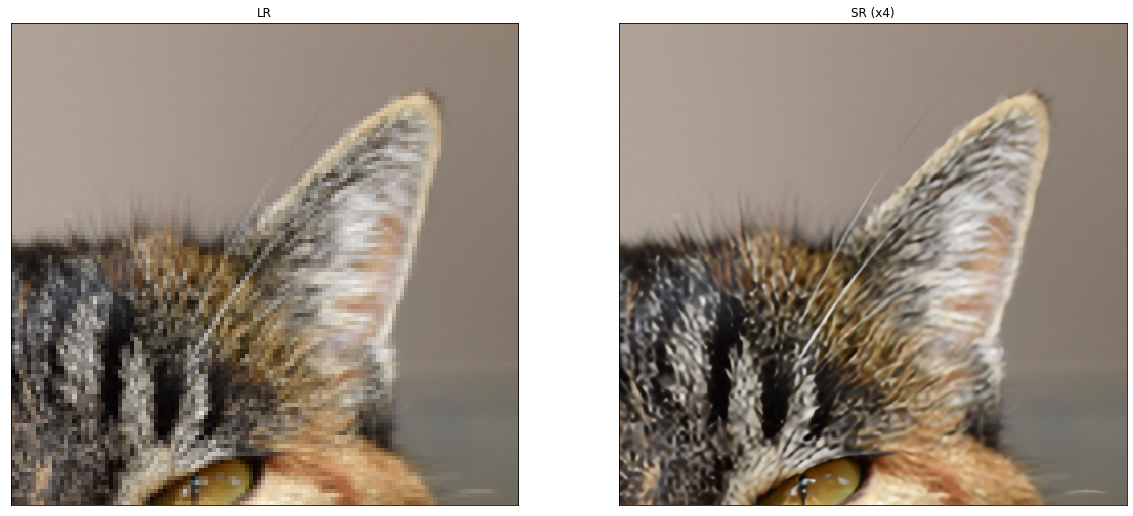

In [23]:
resolve_and_plot('demo/0869x4-crop.png')

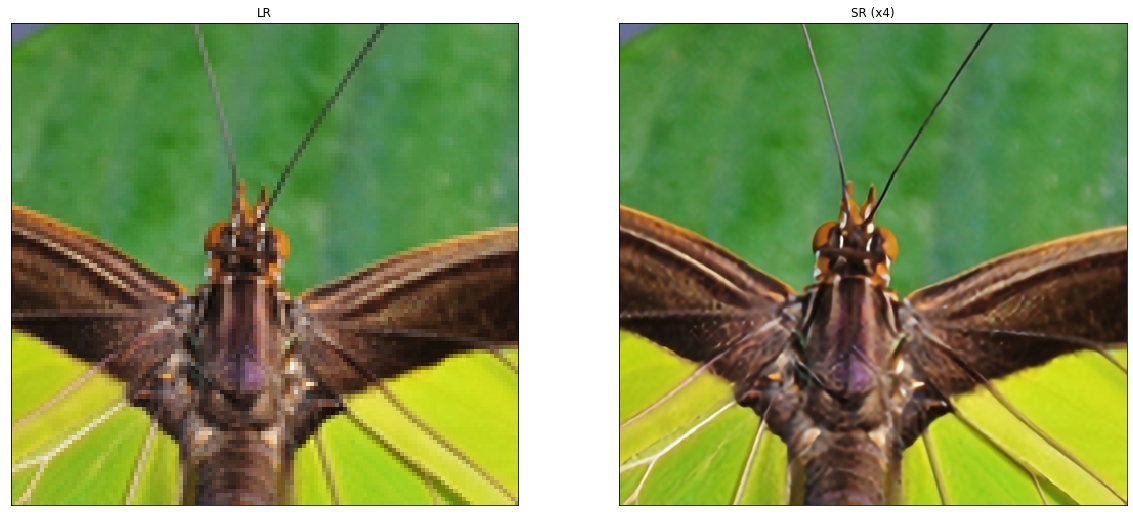

In [24]:
resolve_and_plot('demo/0829x4-crop.png')

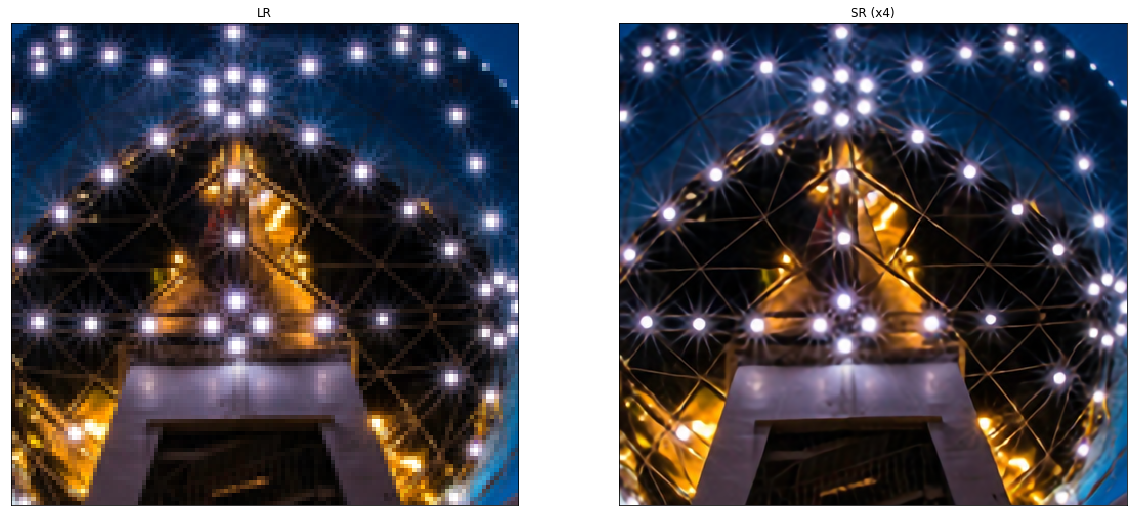

In [25]:
resolve_and_plot('demo/0851x4-crop.png')

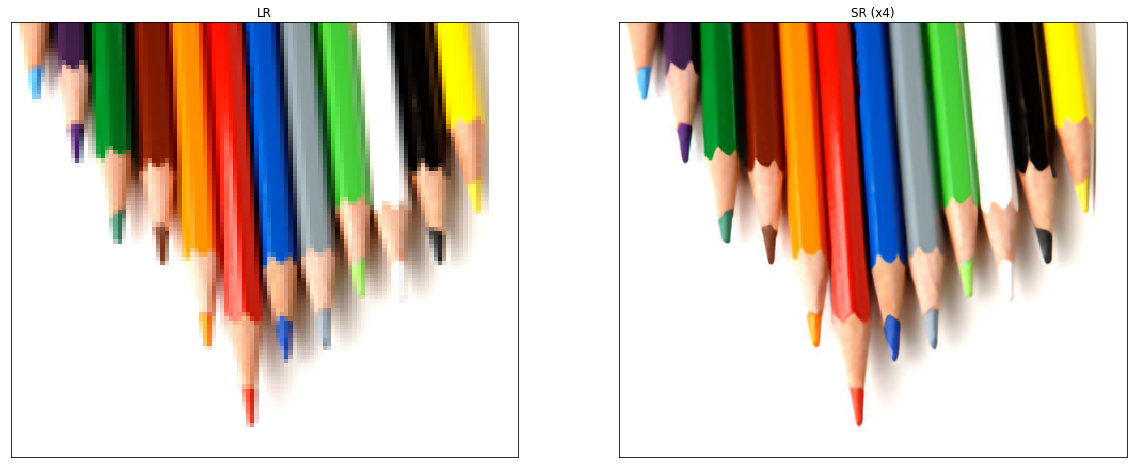

In [26]:
resolve_and_plot('demo/pencil.png')

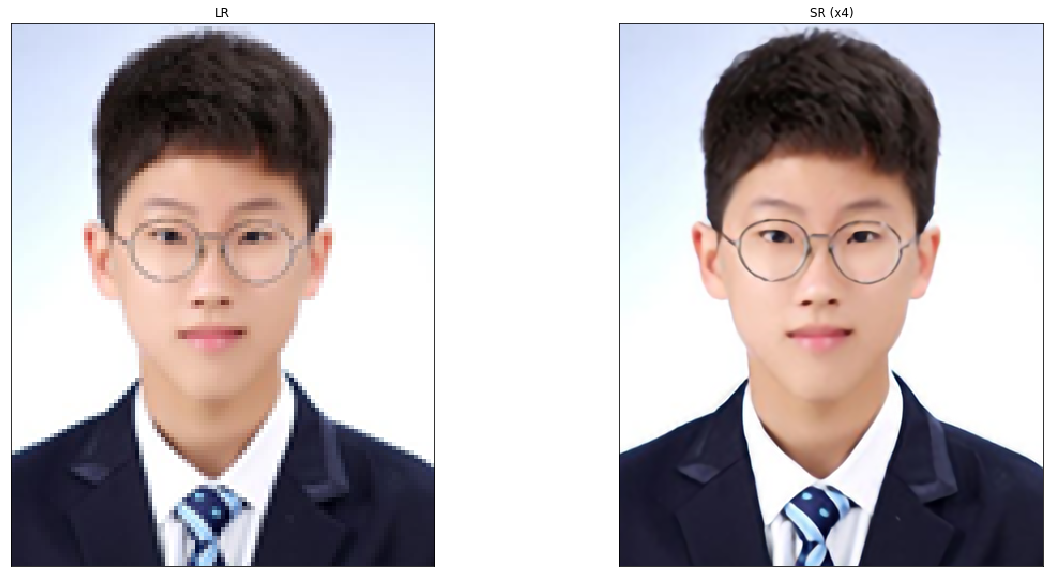

In [27]:
resolve_and_plot('demo/sane.png')

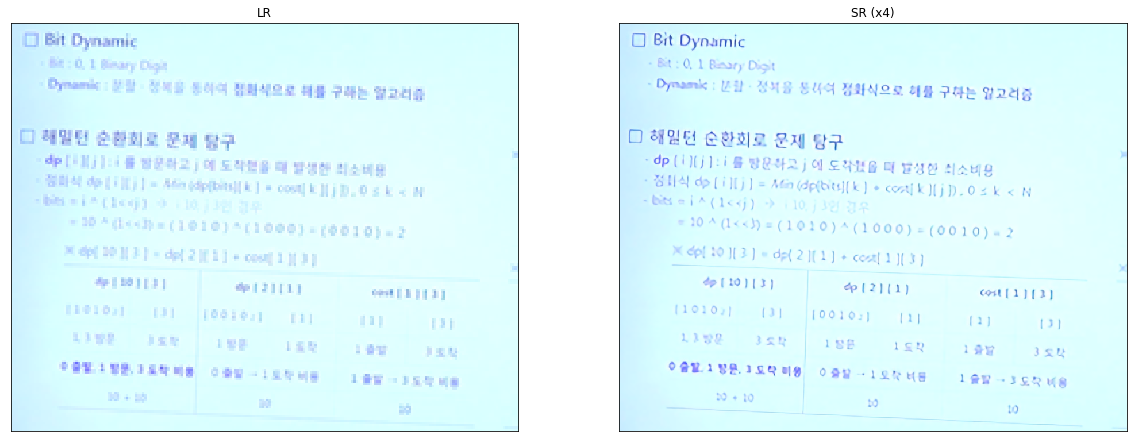

In [28]:
resolve_and_plot('demo/tsp.png')

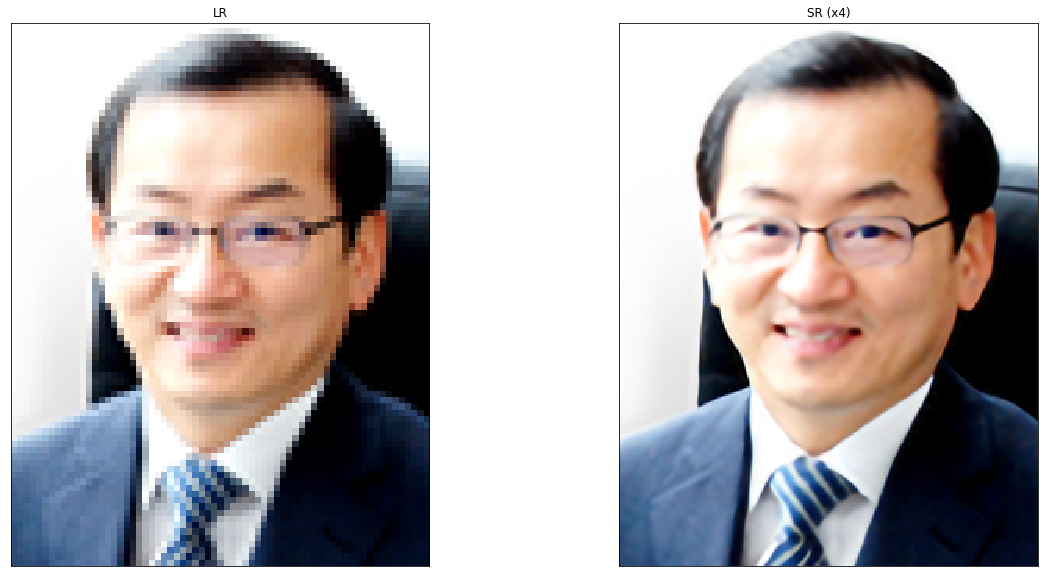

In [29]:
resolve_and_plot('demo/principal.png')